In [119]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from d2l import torch as d2l
from sklearn.svm import SVR
from scipy import stats

plt.rcParams['figure.figsize'] = (8.0, 4.0)
plt.rcParams['savefig.dpi'] = 900
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

seed = 12
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.manual_seed(seed)

In [2]:
def myplot(data, color='green', linewidth=2, label='y', x_label='index', y_label='y'):
    plt.figure(figsize=(15, 3))
    if isinstance(data, torch.Tensor):
        data = data.detach().numpy()
    x = np.arange(0, len(data))
    plt.plot(x, data, color=color, linewidth=linewidth, label=label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.xticks(np.arange(0, len(data), len(data)/10))
    plt.yticks(np.arange(1.2 * min(data), 1.2 * max(data), (max(data)-min(data))/5))
    return plt.gcf()

In [3]:
data = pd.read_csv('./data/water_data.csv', index_col=0)
data

,TM,Z,DRP(63001000),DRP(63203000),DRP(63204401),DRP(63204450),DRP(63204600),DRP(63204650),DRP(63204800),DRP(63204850),...,DRP(63309600),DRP(63310400),DRP(63310600),DRP(63320600),DRP(63403200),DRP(63403500),DRP(63403600),DRP(63404900),TGTQ,TDZ
0,2012/1/1 8:00,2.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1381.5,2.66
1,2012/1/2 8:00,2.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1262.4,2.61
2,2012/1/3 8:00,2.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1293.9,2.35
3,2012/1/4 8:00,2.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1209.0,1.98
4,2012/1/5 8:00,2.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,535.9,1.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,2022/9/24 8:00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3919,2022/9/25 8:00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3920,2022/9/26 8:00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3921,2022/9/27 8:00,NaN,0.0,3.0,1.5,1.5,3.5,1.5,0.0,2.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,NaN,NaN


In [4]:
# 查看空值所在行
data[data.isnull().T.any()]

,TM,Z,DRP(63001000),DRP(63203000),DRP(63204401),DRP(63204450),DRP(63204600),DRP(63204650),DRP(63204800),DRP(63204850),...,DRP(63309600),DRP(63310400),DRP(63310600),DRP(63320600),DRP(63403200),DRP(63403500),DRP(63403600),DRP(63404900),TGTQ,TDZ
3918,2022/9/24 8:00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3919,2022/9/25 8:00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3920,2022/9/26 8:00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3921,2022/9/27 8:00,NaN,0.0,3.0,1.5,1.5,3.5,1.5,0.0,2.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,NaN,NaN
3922,2022/9/28 8:00,NaN,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## 读取数据-29个站点的降雨量数据及水位高度

In [5]:
# 去除空行
water = data[0:-5]

columns = []
columns.append('时间')
columns.append('水位高度')
for i in range(1, 30):
    columns.append('S' + str(i))
columns.append('闸1')
columns.append('闸2')
water.columns = columns
water

,时间,水位高度,S1,S2,S3,S4,S5,S6,S7,S8,...,S22,S23,S24,S25,S26,S27,S28,S29,闸1,闸2
0,2012/1/1 8:00,2.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1381.500,2.66
1,2012/1/2 8:00,2.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1262.400,2.61
2,2012/1/3 8:00,2.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1293.900,2.35
3,2012/1/4 8:00,2.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1209.000,1.98
4,2012/1/5 8:00,2.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,535.900,1.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3913,2022/9/19 8:00,3.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1618.256,2.71
3914,2022/9/20 8:00,3.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1305.200,2.57
3915,2022/9/21 8:00,3.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1520.546,2.23
3916,2022/9/22 8:00,3.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1358.957,2.21


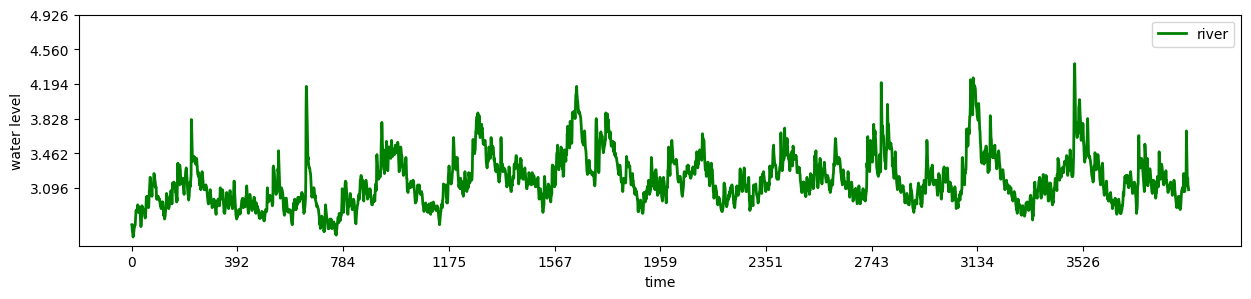

In [6]:
fig = myplot(water['水位高度'], x_label='time', y_label='water level', label='river')
fig.savefig('./results/images/water_level.png',bbox_inches = 'tight')

## 使用RNN作为预测模型

### 数据预处理

In [97]:
# 定义数据预处理函数
def create_datarray(data, n_past):
    features, labels = [], []
    for i in range(n_past, len(data)):
        labels.append(data.iloc[i, 0])
        features.append(data.iloc[i - n_past:i, 0].values)
    return np.array(features), np.array(labels)    

def create_dataset(data, n_past):
    features, labels = create_datarray(data, n_past)
    features_tensor, labels_tensor = torch.tensor(features).float(), torch.tensor(labels).float()
    return TensorDataset(features_tensor, labels_tensor)

def create_dataloader(data, n_past, batch_size, shuffle=False, drop_last=True):
    return DataLoader(
        dataset=create_dataset(data, n_past),
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
    )

In [69]:
# 定义RNN模型
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # 只取最后一个时间步的输出
        return out

In [70]:
def grad_clipping(net, theta):  
    """裁剪梯度。"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def train_rnn(net, train_loader, num_epochs=10, lr=0.01):
    criterion = nn.MSELoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='MSE',
                            legend=['train'], xlim=[1, num_epochs])
    sgd = optim.SGD(net.parameters(), lr)
    loss_cache = []
    for epoch in range(num_epochs):
        timer, metric = d2l.Timer(), d2l.Accumulator(2)
        for features, labels in train_loader:
            if not features.dim() == 3: features = features.unsqueeze(2)
            net.train()
            sgd.zero_grad()
            out = net(features)
            loss = criterion(out.reshape(labels.shape), labels)
            loss.backward()
            grad_clipping(net, 1)
            sgd.step()
            metric.add(loss, labels.numel())
        loss_cache.append(metric[0])
        mse = metric[0] / metric[1]
        speed = metric[1] / timer.stop()
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, [mse])
    # 打印结果
    for idx, val in enumerate(loss_cache):
        print(f'epoch {idx + 1}', f'loss: {val:.3f}')
    print(f'均方误差 {mse:.5f}, {speed:.1f} 标记/秒')
    return animator.fig

In [10]:
water.iloc[:10, 1:-2]

,水位高度,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S20,S21,S22,S23,S24,S25,S26,S27,S28,S29
0,2.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.5,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
7,2.62,2.5,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.5,...,0.0,1.5,1.5,0.0,1.0,0.0,0.5,0.5,0.0,0.0
8,2.64,1.5,0.5,0.2,0.5,0.2,0.5,0.0,0.2,0.5,...,0.0,0.5,1.5,0.0,0.5,0.0,1.0,0.5,0.0,0.0
9,2.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0


### 划分数据集

In [48]:
train_size = int(0.8 * len(water))
test_size = len(water) - train_size
train_data = water.iloc[:train_size, 1:-2]
test_data = water.iloc[train_size:, 1:-2]
train_size, test_size

(3134, 784)

In [71]:
# 定义迭代器
train_loader = create_dataloader(train_data, n_past=7, batch_size=32)

In [72]:
for X,y in train_loader:
    print(X.shape, y.shape)

torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
t

epoch 1 loss: 212.153
epoch 2 loss: 2.685
epoch 3 loss: 2.513
epoch 4 loss: 2.347
epoch 5 loss: 2.190
epoch 6 loss: 2.040
epoch 7 loss: 1.900
epoch 8 loss: 1.768
epoch 9 loss: 1.647
epoch 10 loss: 1.536
epoch 11 loss: 1.437
epoch 12 loss: 1.346
epoch 13 loss: 1.266
epoch 14 loss: 1.187
epoch 15 loss: 1.114
epoch 16 loss: 1.049
epoch 17 loss: 0.990
epoch 18 loss: 0.938
epoch 19 loss: 0.890
epoch 20 loss: 0.846
epoch 21 loss: 0.805
epoch 22 loss: 0.768
epoch 23 loss: 0.734
epoch 24 loss: 0.704
epoch 25 loss: 0.677
epoch 26 loss: 0.652
epoch 27 loss: 0.630
epoch 28 loss: 0.609
epoch 29 loss: 0.589
epoch 30 loss: 0.570
epoch 31 loss: 0.553
epoch 32 loss: 0.537
epoch 33 loss: 0.523
epoch 34 loss: 0.510
epoch 35 loss: 0.499
epoch 36 loss: 0.488
epoch 37 loss: 0.479
epoch 38 loss: 0.470
epoch 39 loss: 0.462
epoch 40 loss: 0.454
epoch 41 loss: 0.447
epoch 42 loss: 0.441
epoch 43 loss: 0.435
epoch 44 loss: 0.430
epoch 45 loss: 0.424
epoch 46 loss: 0.420
epoch 47 loss: 0.415
epoch 48 loss: 0.411

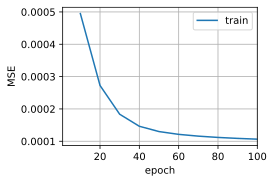

In [73]:
# 定义模型
rnn_model = RNN(1, hidden_size=64, output_size=1)
rnn_fig = train_rnn(rnn_model, train_loader, num_epochs=100, lr=0.01)

In [64]:
rnn_fig.suptitle('')
rnn_fig.texts.clear()
title = f'seed={seed}, hidden={32}, epochs={200}, lr={0.01}'
rnn_fig.text(0.5, 0.97, 'seed=12, hidden=32', ha='center', fontsize=10)
rnn_fig.text(0.5, 0.90, 'epochs=200, lr=0.01', ha='center', fontsize=10)
rnn_fig.savefig('./results/images/multi_rnn_train_process.png', bbox_inches = 'tight')

In [60]:
test_X, test_Y = create_datarray(test_data, n_past=7)
test_X.shape, np.expand_dims(test_X,axis=2).shape 

((777, 7, 30), (777, 7, 1, 30))

In [65]:
rnn_model.eval()
predictions = []
with torch.no_grad():
    expand_X = np.expand_dims(test_X,axis=2)
    tensor_X = torch.tensor(expand_X, dtype=torch.float32)
    output = rnn_model(tensor_X)
    predictions.append(output.detach().numpy().flatten())

In [66]:
ground_truth = test_data.iloc[7:, 0].values
pred = torch.tensor(np.concatenate(predictions), dtype=torch.float32).reshape(-1)
ground_truth.shape, pred.shape

((777,), torch.Size([777]))

### 绘制预测结果

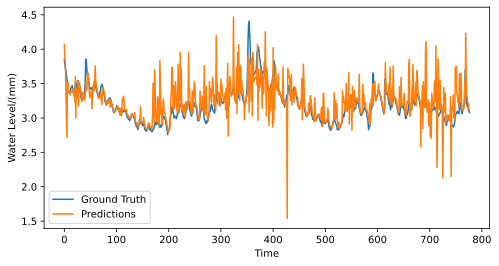

In [67]:
plt.plot(ground_truth, label='Ground Truth')
plt.plot(pred, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Water Level/(mm)')
plt.legend()
plt.gcf().savefig('./results/images/multi_rnn_predict.png', bbox_inches = 'tight')
plt.show()

## 使用SVR作为预测模型

In [98]:
n_past = 7
train_ratio = 0.8
train_size = int(train_ratio * len(data))
data_train = water.iloc[:train_size, 1:-2]
data_test = water.iloc[train_size:, 1:-2]

X_train, y_train = create_datarray(data_train, n_past)
X_test, y_test = create_datarray(data_test, n_past)
X_train.shape, y_train.shape, X_train.reshape(X_train.shape[0], -1).shape

((3131, 7), (3131,), (3131, 7))

In [99]:
# 找出异常值
level_mean_train, level_std_train = y_train.mean(), y_train.std()

# 使用三倍sigma原则筛选异常值
lower_bound_train = level_mean_train - 3 * level_std_train
upper_bound_train = level_mean_train + 3 * level_std_train
outliers = data_train[(data_train['水位高度'] < lower_bound_train) | (data_train['水位高度'] > upper_bound_train)]

out_idx = outliers.index
out_idx

Int64Index([ 647,  648,  649, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652,
            1653, 2778, 2779, 2801, 3109, 3110, 3111, 3112, 3113, 3114, 3118,
            3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129],
           dtype='int64')

In [100]:
X_train[:10, :], y_train[:10]

(array([[2.71, 2.7 , 2.65, 2.63, 2.61, 2.58, 2.6 ],
        [2.7 , 2.65, 2.63, 2.61, 2.58, 2.6 , 2.62],
        [2.65, 2.63, 2.61, 2.58, 2.6 , 2.62, 2.64],
        [2.63, 2.61, 2.58, 2.6 , 2.62, 2.64, 2.67],
        [2.61, 2.58, 2.6 , 2.62, 2.64, 2.67, 2.68],
        [2.58, 2.6 , 2.62, 2.64, 2.67, 2.68, 2.71],
        [2.6 , 2.62, 2.64, 2.67, 2.68, 2.71, 2.7 ],
        [2.62, 2.64, 2.67, 2.68, 2.71, 2.7 , 2.72],
        [2.64, 2.67, 2.68, 2.71, 2.7 , 2.72, 2.77],
        [2.67, 2.68, 2.71, 2.7 , 2.72, 2.77, 2.84]]),
 array([2.62, 2.64, 2.67, 2.68, 2.71, 2.7 , 2.72, 2.77, 2.84, 2.86]))

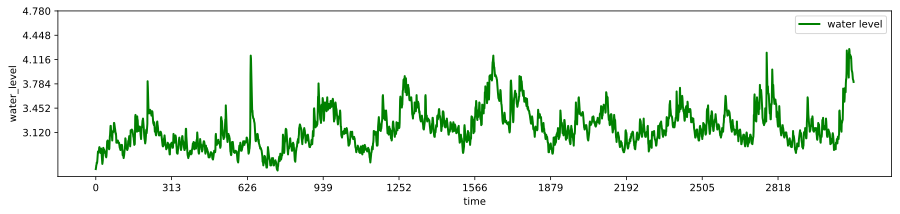

In [78]:
y_train_fig = myplot(y_train, y_label='water_level', x_label='time', label='water level')

In [91]:
# X_train = X_train.reshape(X_train.shape[0], -1)
# X_test = X_test.reshape(X_test.shape[0], -1)

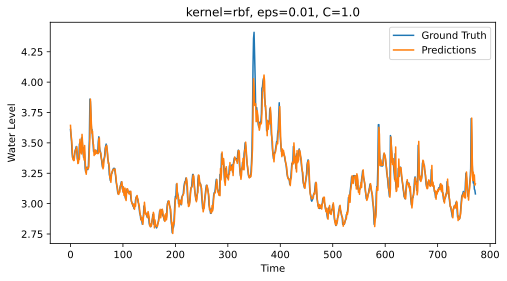

In [101]:
# 创建SVR模型并拟合数据
svr_model = SVR(kernel='rbf',epsilon=0.01,C=1.0)
svr_model.fit(X_train, y_train)

# 在测试集上进行预测
predictions_test = svr_model.predict(X_test)

# 绘制预测结果和实际结果的图表
plt.plot(y_test, label='Ground Truth')
plt.plot(predictions_test, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Water Level')
plt.legend()
plt.title('kernel=rbf, eps=0.01, C=1.0')
plt.savefig('./results/images/svr_predict.png', bbox_inches = 'tight')
plt.show()

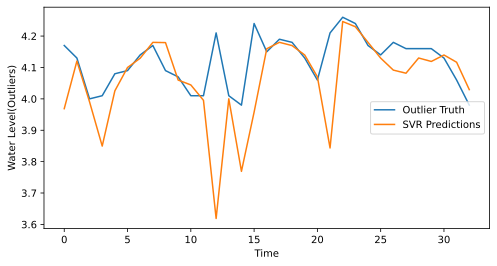

In [103]:
predictions_train = svr_model.predict(X_train)
# svr在异常值上的表现
plt.plot(range(len(outliers['水位高度'])), outliers['水位高度'], label='Outlier Truth')
plt.plot(range(len(outliers['水位高度'])), predictions_train[out_idx - 7], label='SVR Predictions')
plt.xlabel('Time')
plt.ylabel('Water Level(Outliers)')
plt.legend(loc="right")
plt.savefig('./results/images/svr_predict_outliers.png', bbox_inches = 'tight')

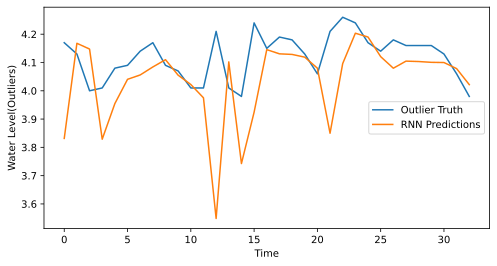

In [105]:
# rnn在异常值上的表现
train_X, train_Y = create_datarray(train_data, n_past=7)
predictions_rnn = []
with torch.no_grad():
    expand_X = np.expand_dims(train_X,axis=2)
    tensor_X = torch.tensor(expand_X, dtype=torch.float32)
    output = rnn_model(tensor_X)
    predictions_rnn.append(output.detach().numpy().flatten())
pred = torch.tensor(np.concatenate(predictions_rnn), dtype=torch.float32).reshape(-1)
    
plt.plot(range(len(outliers['水位高度'])), outliers['水位高度'], label='Outlier Truth')
plt.plot(range(len(outliers['水位高度'])), pred[out_idx - 7], label='RNN Predictions')
plt.xlabel('Time')
plt.ylabel('Water Level(Outliers)')
plt.legend(loc="right")
plt.savefig('./results/images/rnn_predict_outliers.png', bbox_inches = 'tight')

### 使用所有值训练svr_dff

In [106]:
diff_labels = y_train - predictions_train

X_train_diff = X_train
y_train_diff = diff_labels

svr_model_diff = SVR(kernel='rbf', epsilon=0.01)
svr_model_diff.fit(X_train_diff, y_train_diff)

SVR(epsilon=0.01)

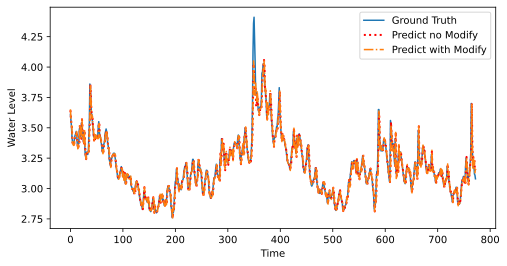

In [109]:
predictions_diff = svr_model_diff.predict(X_test)
predictions_final = predictions_test + predictions_diff

# 绘制预测结果和实际结果的图表
plt.plot(y_test, label='Ground Truth', linestyle='-', linewidth=1.5)
plt.plot(predictions_test, label='Predict no Modify', linestyle=':', linewidth=2, color='r')
plt.plot(predictions_final, label='Predict with Modify', linestyle='-.')
plt.xlabel('Time')
plt.ylabel('Water Level')
plt.legend()
plt.savefig('./results/images/svr_useall_modify_predict.png', bbox_inches = 'tight')
plt.show()

### 使用异常值训练svr_diff,修正所有值

In [110]:
diff_labels = outliers['水位高度'] - predictions_train[out_idx - 7]

X_train_diff = X_train[out_idx - 7]
y_train_diff = diff_labels

svr_model_diff = SVR(kernel='rbf', epsilon=0.01)
svr_model_diff.fit(X_train_diff, y_train_diff)

SVR(epsilon=0.01)

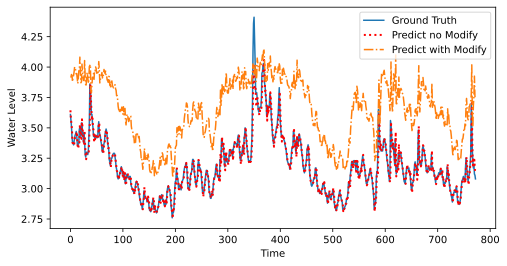

In [112]:
predictions_diff = svr_model_diff.predict(X_test)
predictions_final = predictions_test + predictions_diff

# 绘制预测结果和实际结果的图表
plt.plot(y_test, label='Ground Truth', linestyle='-', linewidth=1.5)
plt.plot(predictions_test, label='Predict no Modify', linestyle=':', linewidth=2, color='r')
plt.plot(predictions_final, label='Predict with Modify', linestyle='-.')
plt.xlabel('Time')
plt.ylabel('Water Level')
plt.legend()
plt.savefig('./results/images/svr_useout_modify_all_predict.png', bbox_inches = 'tight')
plt.show()

### 使用异常值训练svr_diff,修正异常值

In [113]:
diff_labels = outliers['水位高度'] - predictions_train[out_idx - 7]

X_train_diff = X_train[out_idx - 7]
y_train_diff = diff_labels

svr_model_diff = SVR(kernel='rbf', epsilon=0.01)
svr_model_diff.fit(X_train_diff, y_train_diff)

SVR(epsilon=0.01)

In [114]:
# 找出异常值
level_mean_test, level_std_test = y_test.mean(), y_test.std()

# 使用三倍sigma原则筛选异常值
lower_bound_test = level_mean_test - 3 * level_std_test
upper_bound_test = level_mean_test + 3 * level_std_test

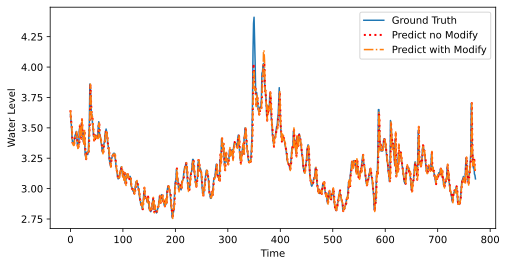

In [115]:
predictions_diff = svr_model_diff.predict(X_test)
predictions_final = np.where((predictions_test < lower_bound_train) | (predictions_test > upper_bound_train), predictions_test + predictions_diff, predictions_test)

# 绘制预测结果和实际结果的图表
plt.plot(y_test, label='Ground Truth', linestyle='-', linewidth=1.5)
plt.plot(predictions_test, label='Predict no Modify', linestyle=':', linewidth=2, color='r')
plt.plot(predictions_final, label='Predict with Modify', linestyle='-.')
plt.xlabel('Time')
plt.ylabel('Water Level')
plt.legend()
plt.savefig('./results/images/svr_useout_modify_outliers_predict.png', bbox_inches = 'tight')
plt.show()

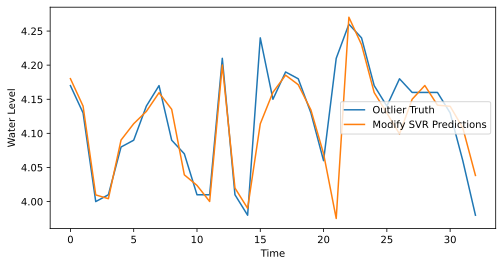

In [117]:
# 修正后的svr在异常值上的表现
outliers_diff = svr_model_diff.predict(X_train[out_idx - 7])
predictions_train_modify = predictions_train[out_idx - 7] + outliers_diff

plt.plot(range(len(outliers['水位高度'])), outliers['水位高度'], label='Outlier Truth')
plt.plot(range(len(outliers['水位高度'])), predictions_train_modify, label='Modify SVR Predictions')
plt.xlabel('Time')
plt.ylabel('Water Level')
plt.legend(loc="right")
plt.savefig('./results/images/svr_useout_modify_outliers.png', bbox_inches = 'tight')

## 采用Bootstrap方法判断异常值

In [124]:
n_past = 7
train_ratio = 0.8
train_size = int(train_ratio * len(data))
data_train = water.iloc[:train_size, 1:-2]
data_test = water.iloc[train_size:, 1:-2]

X_train, y_train = create_datarray(data_train, n_past)
X_test, y_test = create_datarray(data_test, n_past)

In [125]:
svr = SVR()

# 设置Bootstrap抽样次数和置信水平
n_bootstrap = 1000
confidence_level = 0.95

# 初始化预测结果列表
predictions = []

# 进行Bootstrap抽样和预测
for i in range(n_bootstrap):
    # 从原始数据集中有放回地抽样，生成Bootstrap样本
    bootstrap_sample_indices = np.random.choice(range(len(X_train)), size=len(X_train), replace=True)
    bootstrap_sample_X = X_train[bootstrap_sample_indices]
    bootstrap_sample_y = y_train[bootstrap_sample_indices]
    
    # 使用SVR模型进行训练和预测
    svr.fit(bootstrap_sample_X, bootstrap_sample_y)
    y_pred = svr.predict(X_train)
    
    # 将预测结果添加到列表中
    predictions.append(y_pred)

# 计算预测结果的均值和标准差
predictions_mean = np.mean(predictions, axis=0)
predictions_std = np.std(predictions, axis=0)

# 计算置信区间的上下限
z_score = 1.96  # 对应于95%置信水平的z值
lower_bound = predictions_mean - z_score * predictions_std
upper_bound = predictions_mean + z_score * predictions_std

# 打印置信区间
print("置信区间下限:", lower_bound)
print("置信区间上限:", upper_bound)

置信区间下限: [2.68589239 2.71085871 2.7371251  ... 3.85950162 3.83898495 3.82020454]
置信区间上限: [2.73218072 2.75002463 2.77004124 ... 3.94200749 3.92159515 3.90299756]


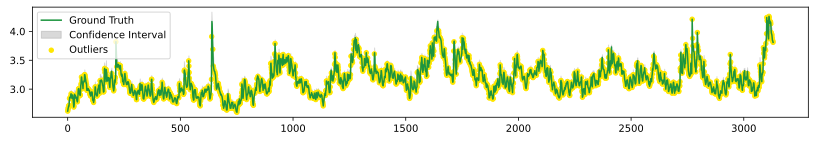

In [204]:
out_idx = np.where((y_train < lower_bound) | (y_train > upper_bound))
outliers = y_train[out_idx]

plt.figure(figsize=(14, 2), dpi=600)
# 绘制数据和异常值标注
plt.plot(range(len(y_train)), y_train, label='Ground Truth', color='#1d953f')
plt.fill_between(range(len(y_train)), lower_bound, upper_bound, color='gray', alpha=0.3, label='Confidence Interval')
plt.scatter(out_idx, outliers, color='#ffe600', label='Outliers', s=20)
plt.legend()
plt.show()

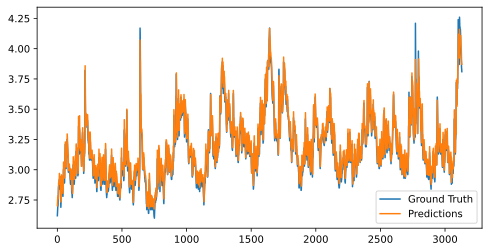

In [197]:
predictions = svr.predict(X_train)
plt.plot(range(len(y_train)), y_train, label='Ground Truth')
plt.plot(range(len(y_train)), predictions, label='Predictions')
plt.legend()

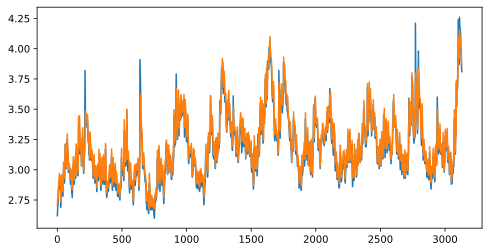

In [202]:
plt.plot(out_idx[0], y_train[out_idx], label='Outliers')
plt.plot(out_idx[0], predictions[out_idx], label='Predictions')

In [205]:
diff_labels = outliers - predictions[out_idx]

X_train_diff = X_train[out_idx]
y_train_diff = diff_labels

svr_model_diff = SVR(kernel='rbf', epsilon=0.01)
svr_model_diff.fit(X_train_diff, y_train_diff)

SVR(epsilon=0.01)

In [207]:
svr_model_diff.predict(X_train[out_idx])

array([-0.07612475, -0.06742129, -0.07567028, ..., -0.06854425,
       -0.07065241, -0.07131629])

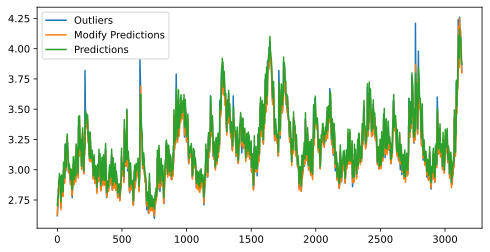

In [210]:
plt.plot(out_idx[0], y_train[out_idx], label='Outliers')
plt.plot(out_idx[0], predictions[out_idx] + svr_model_diff.predict(X_train[out_idx]), label='Modify Predictions')
plt.plot(out_idx[0], predictions[out_idx], label='Predictions')
plt.legend()

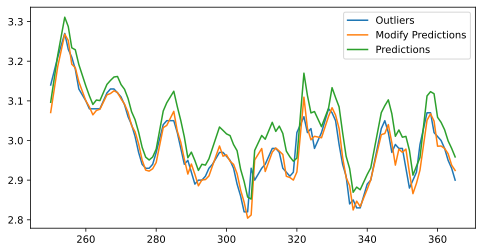

In [212]:
plt.plot(out_idx[0][200:300], y_train[out_idx][200:300], label='Outliers')
plt.plot(out_idx[0][200:300], (predictions[out_idx] + svr_model_diff.predict(X_train[out_idx]))[200:300], label='Modify Predictions')
plt.plot(out_idx[0][200:300], predictions[out_idx][200:300], label='Predictions')
plt.legend()

In [214]:
r = range(train_size, len(data))
prediction_test = svr.predict(X_test)
prediction_test.shape, r

((773,), range(3138, 3923))